## Setting file paths

#### RDM Model 

In [12]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

plots_folder_name = 'RDM/'
dataset_name = 'fastText_subtlex_FC.csv'
stan_file_name = 'RDM_hier_3d.stan'
saved_model_name = '3D'

plots_path = plots_root + plots_folder_name
dataset_path = datasets_root + dataset_name
stan_file_path = stan_files_root + stan_file_name
saved_model_path = saved_models_root + saved_model_name + '_RDM'  + '.pkl'

## Importing Packages

In [2]:
import numpy as np
import pandas as pd
import pystan
import rlssm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from scipy.stats import gaussian_kde

sns.set_theme(style="whitegrid")


Bad key "text.kerning_factor" on line 4 in
/home/a.dadras/.conda/envs/ANNDDM/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [3]:
word_nword_df = pd.read_csv(dataset_path, header=None, names =['string', 'freq',  'label', 'zipf','category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,repetitions,496,1,2.069985,LF,1.000000e+00,1.770500e-08
1,fettle,0,0,0.000000,NW,1.454335e-02,9.854567e-01
2,compulsidaty,0,0,0.000000,NW,8.829454e-04,9.991171e-01
3,fegaphone,0,0,0.000000,NW,6.154092e-03,9.938459e-01
4,crel's,0,0,0.000000,NW,7.677795e-04,9.992322e-01
...,...,...,...,...,...,...,...
74312,jeeds,0,0,0.000000,NW,1.754459e-07,9.999999e-01
74313,jidelong,0,0,0.000000,NW,4.784017e-04,9.995216e-01
74314,aft,934,1,3.549513,LF,9.998860e-01,1.139512e-04
74315,Ikanian,0,0,0.000000,NW,2.045738e-07,9.999998e-01


In [4]:
def remove_outliers(df, max_rt, min_rt, std_c=2.5):
    """
    Returns remove outliers from dataframes. Outlier RTs are bigger than
    max_rt and smaller than min_rt. Also RTsthat are out of -/+ (std_c * sd) 
    of mean RT interval are considered as outliers too.

    Parameters
    ----------
        df: pandas dataframe with rt column
        max_rt (float): maximum acceptable rt
        min_rt (float): minimum acceptable rt
        
    Optional Parameters
    ----------
        std_c (float) : Optional
            coefficient to define interval of non-outlier RTs
    
    Returns
    -------
        df: pandas dataframe without outliers  
    """
    mean = df['rt'].mean()
    sd = df['rt'].std()
    lower_thr = mean - std_c*sd
    upper_thr = mean + std_c*sd
    min_bound = max(min_rt, lower_thr)
    max_bound = min(max_rt, upper_thr)
    df = df[df['rt'] >= min_bound]
    df = df[df['rt'] <= max_bound]
    return df

Reading and modifing each behavioral data file and combining all of them into a single behavioral dataframe

In [5]:
Number_Of_Participants = 5
Number_Of_Trials = 400
dataframes = []

for i in range(Number_Of_Participants):
    # Loading each file
    df = pd.read_csv(behavioural_data_root + str(i+1) + "DATA.LDT", names=['trial', 'string_id', 'string_type', 'accuracy', 'rt', 'string'])
    # Dropping non rows and first two rows that are demographic informations 
    df = df.dropna().drop('string_id', axis=1).drop([0, 1]).iloc[:Number_Of_Trials] 
    # Converting columns type to suitable data types
    convert_dict = {'string_type': 'int16',
                    'accuracy': 'int16',
                    'rt': float
                   }

    df = df.astype(convert_dict)
    # Convert RTs to seconds
    df['rt'] = df['rt'].apply(lambda x: x/1000) 
    # Removing Outliers
    df = remove_outliers(df, 3, .2, 2.5)
    # Extracting response of participant from his/her accuracy
    df['response'] = np.logical_not(np.logical_xor(df['string_type'], df['accuracy'])).astype('int')
    df = df.reset_index(drop=True)
    # Particpant number
    df['participant'] = i+1
    # Minimum RT of participant in all trials (is needed for stan code)
    df['minRT'] = df['rt'].min()
    dataframes.append(df)

In [6]:
# Combining dataframes
behavioural_df = pd.concat(dataframes)
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["trial", "string_type", "freq"], axis=1)

In [7]:
behavioural_df.head()

,accuracy,rt,string,response,participant,minRT,label,zipf,category,word_prob,non_word_prob
0,0,0.707,bookie,0,1,0.412,1.0,3.409105,LF,1.000000,1.803803e-07
1,1,0.769,gandbrake,0,1,0.412,0.0,0.000000,NW,0.001226,9.987740e-01
2,1,0.526,philosophical,1,1,0.412,1.0,3.205648,LF,0.999862,1.382707e-04
3,0,0.510,umbeaten,1,1,0.412,0.0,0.000000,NW,0.007453,9.925471e-01
4,1,0.512,belonging,1,1,0.412,1.0,3.317140,LF,1.000000,1.911451e-07


Predicted probabilities of words and non-words in different conditions in all trials
across participants

In [8]:
behavioural_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'non_word_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                         non_word_prob  \
              mean       std count       max           min          mean   
category                                                                   
HF        0.999844  0.001011    91  1.000000  9.906882e-01      0.000156   
LF        0.990438  0.082460   763  1.000000  7.522420e-04      0.009562   
NW        0.004913  0.026677   933  0.646109  9.891284e-20      0.995087   

                                                  
               std count       max           min  
category                                          
HF        0.001011    91  0.009312  5.545796e-21  
LF        0.082460   763  0.999248  3.344377e-20  
NW        0.026677   933  1.000000  3.538906e-01

RT and response description of words and non-words in different conditions in all trials
across participants

In [9]:
behavioural_df.groupby(['category']).agg({'rt': ['mean', 'std', 'max', 'min'], 'response': ['mean', 'std', 'max', 'min']})

rt                          response                  
              mean       std    max    min      mean       std max min
category                                                              
HF        0.559253  0.162808  1.262  0.301  1.000000  0.000000   1   1
LF        0.663617  0.214092  1.707  0.271  0.888598  0.314836   1   0
NW        0.740148  0.225628  1.763  0.200  0.143623  0.350895   1   0

## Stan Model and Estimation

Compiling stan model

In [13]:
rdm_model = pystan.StanModel(file=stan_file_path)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8bef4439324228bc278c37c462dcf72b NOW.


Preparing model's inputs

In [28]:
N = len(behavioural_df)
participant = behavioural_df['participant'].to_numpy()
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy()
response = behavioural_df['response'].to_numpy().astype(int)
rt = behavioural_df['rt'].to_numpy()                      
minRT = behavioural_df['minRT'].to_numpy()
RTbound = 0

threshold_priors = [4, 2, 1, 2] 
drift_priors = [0, 2, 0, 1] 
ndt_priors = [0, 1, 1, 1];

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'frequencyCondition': frequencyCondition,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'threshold_priors': threshold_priors,
             'drift_priors': drift_priors,
             'ndt_priors': ndt_priors,
             }

# set sampling parameters
n_iter = 1000
n_warmup = int(n_iter/2)
n_chains = 2

Fitting the model

In [27]:
fit = rdm_model.sampling(data=data_dict,
                             iter=n_iter, 
                             warmup=n_warmup,
                             chains=n_chains,
                             verbose=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Model diagnostics

In [29]:
print("***hmc diagnostics:")
print(pystan.check_hmc_diagnostics(fit), flush=True)

***hmc diagnostics:


{'n_eff': True, 'Rhat': True, 'divergence': False, 'treedepth': False, 'energy': True}


In [30]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

print("***DF: ")
df

***DF: 


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu_ndt,-0.397760,0.023647,0.433900,-1.351317,-0.634645,-0.352131,-0.109944,0.352902,336.689916,1.011914
mu_threshold_word,1.249561,0.016497,0.293708,0.674317,1.087559,1.239443,1.400359,1.923987,316.981801,1.006333
mu_threshold_nonword,2.046494,0.020648,0.388605,1.354054,1.843595,2.029418,2.199706,2.947636,354.226170,1.002129
mu_drift_word[1],4.706821,0.042939,0.727292,3.091839,4.279455,4.737648,5.202472,6.045976,286.887304,1.008544
mu_drift_word[2],3.282523,0.023388,0.427003,2.240293,3.050109,3.316395,3.560424,3.980771,333.317399,1.009206
...,...,...,...,...,...,...,...,...,...,...
log_lik[1784],0.972134,0.003995,0.124668,0.673810,0.899745,0.997475,1.062400,1.151789,973.716783,0.998235
log_lik[1785],-1.645492,0.008317,0.245034,-2.162594,-1.807604,-1.625803,-1.468429,-1.197898,867.907427,1.001644
log_lik[1786],-4.656261,0.009342,0.318310,-5.295044,-4.868347,-4.654752,-4.433351,-4.042714,1160.886609,1.002003
log_lik[1787],0.123748,0.002098,0.062178,-0.006532,0.084886,0.125821,0.167258,0.243158,877.988702,1.002920


In [31]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["Rhat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
386


In [32]:
df.loc[df['Rhat']>1.01]

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu_ndt,-0.397760,0.023647,0.433900,-1.351317,-0.634645,-0.352131,-0.109944,0.352902,336.689916,1.011914
sd_ndt,0.902175,0.048503,0.602746,0.115665,0.417264,0.794766,1.260262,2.397180,154.431673,1.010743
z_ndt[3],-0.089678,0.034773,0.611577,-1.494965,-0.437847,-0.050560,0.335245,0.970506,309.326616,1.013012
z_ndt[5],-0.314208,0.043147,0.652640,-1.898133,-0.686417,-0.250222,0.114186,0.770134,228.799872,1.013237
"z_drift_word[2,2]",-1.191415,0.033896,0.660603,-2.514676,-1.616481,-1.182505,-0.763004,0.038521,379.830534,1.013678
...,...,...,...,...,...,...,...,...,...,...
log_lik[548],0.544545,0.006849,0.091618,0.351404,0.492663,0.544012,0.604597,0.717067,178.941249,1.016698
log_lik[576],0.626095,0.007289,0.117960,0.365997,0.558450,0.632868,0.706697,0.830457,261.905652,1.014901
log_lik[592],0.639118,0.006273,0.147934,0.298628,0.551944,0.652337,0.740088,0.892596,556.147319,1.010712
log_lik[623],0.581930,0.007149,0.100357,0.362931,0.524775,0.584167,0.647836,0.763999,197.048573,1.016652


In [33]:
df.loc[df['Rhat']>1.01].describe()

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,0.035401,0.005776,0.062065,-0.059809,-0.014218,0.028322,0.084508,0.154518,98.755474,1.019169
std,1.062232,0.021249,0.214312,1.363377,1.290237,1.007002,0.900579,0.762365,48.600067,0.001697
min,-18.576852,0.003162,0.029624,-23.025851,-23.025851,-17.596246,-15.566791,-12.877849,87.760730,1.010712
25%,0.133452,0.003162,0.029624,0.101432,0.109546,0.120379,0.159236,0.199487,87.760730,1.019598
50%,0.133452,0.003162,0.029624,0.101432,0.109546,0.120379,0.159236,0.199487,87.760730,1.019598
75%,0.133452,0.003162,0.029624,0.101432,0.109546,0.120379,0.159236,0.199487,87.760730,1.019598
max,0.902175,0.379580,3.608188,0.367624,0.563829,0.794766,1.260262,2.397180,556.147319,1.021055


Saving Model

In [34]:
with open(saved_model_path, "wb") as f:
    pickle.dump({'model' : rdm_model, 'fit' : fit}, f, protocol=-1)

/home/a.dadras/.conda/envs/ANNDDM/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


## Check parameters

Loading Model

In [35]:
with open(saved_model_path, "rb") as f:
    data_dict = pickle.load(f)

fit = data_dict['fit']

Parameters posterior plots

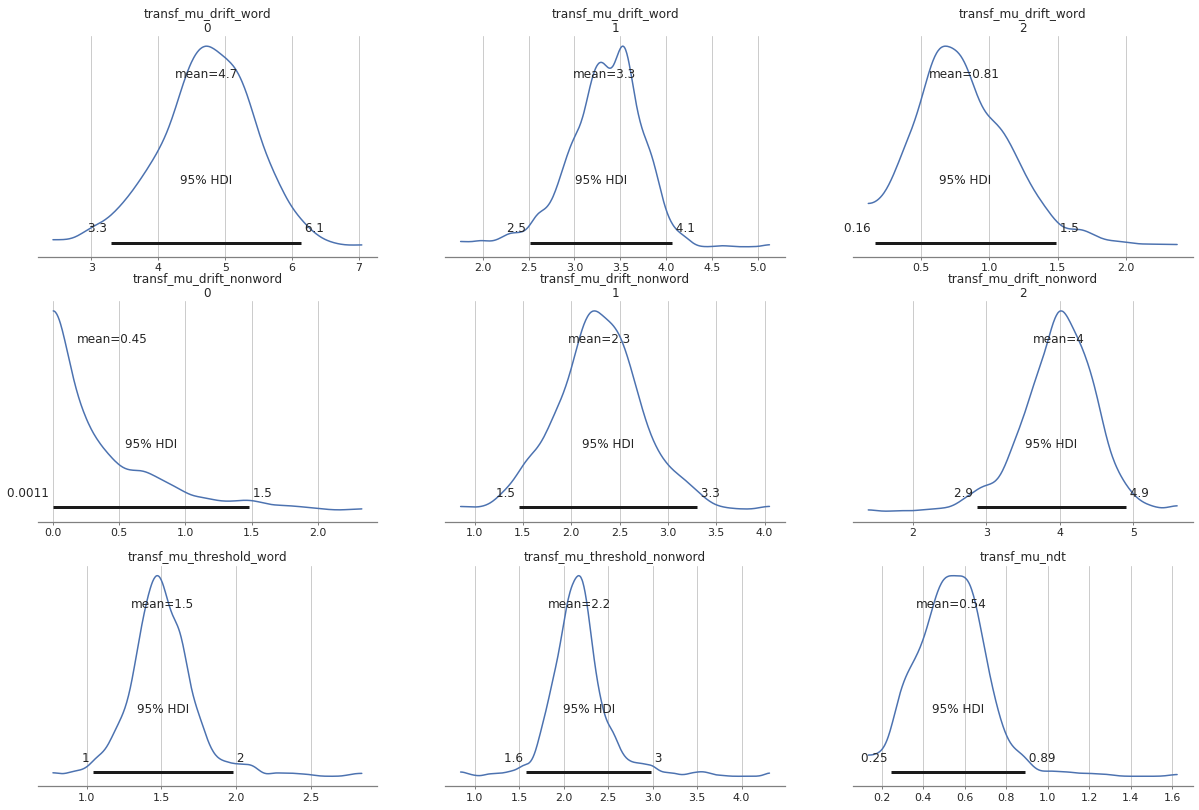

In [39]:
az.plot_posterior(fit, var_names=['transf_mu_drift_word', 'transf_mu_drift_nonword', 'transf_mu_threshold_word', 'transf_mu_threshold_nonword', 'transf_mu_ndt'], hdi_prob=.95);
plt.savefig(plots_path + 'Parameters')

#### Models mean parameters in different conditions

In [40]:
# Loading model parameters for each trial
drift_word_t = fit['drift_word_t']
drift_nonword_t = fit['drift_nonword_t']
threshold_t_word = fit['threshold_t_word']
threshold_t_nonword = fit['threshold_t_nonword']
ndt_t = fit['ndt_t']

In [41]:
HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [42]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))

HF words, word drift mean and std:
5.190024260961511 0.24683770137239594
HF words, nonword drift mean and std:
0.4706167158638626 0.4452428422457029


In [43]:
print('LF words word drift mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))

LF words word drift mean and std:
3.473493056215646 0.13459453912073668
LF words nonword drift mean and std:
2.420126676567076 0.17366758608714541


In [44]:
print('NW words word drift mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

NW words word drift mean and std:
0.9656770069597842 0.15154023367511274
NW words nonword drift mean and std:
4.192485564348274 0.13577010337448137


In [45]:
HF_condition_w = threshold_t_word[:, behavioural_df['category']=="HF"]
HF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="HF"]
LF_condition_w = threshold_t_word[:, behavioural_df['category']=="LF"]
LF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="LF"]
NW_condition_w = threshold_t_word[:, behavioural_df['category']=="NW"]
NW_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="NW"]

In [46]:
print('HF words, word threshold mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword threshold mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))

HF words, word threshold mean and std:
1.4903631582836934 0.07976575620863337
HF words, nonword threshold mean and std:
2.139682768714901 0.09976627391679652


In [47]:
print('LF words word threshold mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword threshold mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))

LF words word threshold mean and std:
1.4713383232385835 0.08036289405985939
LF words nonword threshold mean and std:
2.122344939173802 0.0995551288381507


In [48]:
print('NW words word threshold mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword threshold mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

NW words word threshold mean and std:
1.4765346581981351 0.08010610969355361
NW words nonword threshold mean and std:
2.1261759489104186 0.09942588632399234


In [49]:
HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [50]:
print('HF words ndt_t mean and std:')
print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))

HF words ndt_t mean and std:
0.2334371449537949 0.013315075530052662


In [51]:
print('LF words ndt_t mean and std:')
print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))

LF words ndt_t mean and std:
0.23466307352702573 0.013075896814602727


In [52]:
print('Non Words ndt_t mean and std:')
print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

Non Words ndt_t mean and std:
0.2330114155994384 0.013209964640963438


## Calculating metrics

In [53]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [54]:
log_likelihood = fit['log_lik']
calculate_waic(log_likelihood)

{'lppd': 303.06027632872247,
 'p_waic': 50.32766552370701,
 'waic': -505.4652216100309,
 'waic_se': 107.99050932469716}

## Simulating RDM with estimated parameters

In [55]:
def random_rdm_2A(cor_drift, inc_drift, threshold_word, threshold_nonword, ndt, noise_constant=1, dt=0.001, max_rt=10):
    """ 
    Simulates behavior (rt and accuracy) according to the Racing Diffusion Model.
     
    Parameters
    ----------
    cor_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - correct trials.
    inc_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - incorrect trials.
    threshold : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Threshold of the diffusion decision model.
    ndt : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Non decision time of the diffusion decision model, in seconds.
    
    Optional Parameters
    ----------------
    noise_constant : float, default 1
        Scaling factor of the Racing Diffusion Model.
        If changed, drift and threshold would be scaled accordingly.
        Not to be changed in most applications.
    dt : float, default 0.001
        Controls the time resolution of the Racing Diffusion Model. Default is 1 msec.
        Lower values of dt make the function more precise but much slower.
    max_rt : float, default 10
        Controls the maximum rts that can be predicted.
        Making this higher might make the function a bit slower.
    
    Returns
    -------
    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    acc: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated accuracy according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    """
    shape = cor_drift.shape
    acc = np.empty(shape)
    rt = np.empty(shape)
    acc[:] = np.nan
    rt[:] = np.nan

    max_tsteps = max_rt/dt

    x_cor = np.zeros(shape)
    x_inc = np.zeros(shape)

    tstep = 0
    ongoing = np.array(np.ones(shape), dtype=bool)

    stop_race = False

    while np.sum(ongoing) > 0 and tstep < max_tsteps:
        x_cor[ongoing] += np.random.normal(cor_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        x_inc[ongoing] += np.random.normal(inc_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        tstep += 1
        ended_correct = (x_cor >= threshold_word)
        ended_incorrect = (x_inc >= threshold_nonword)

        # store results and filter out ended trials
        if np.sum(ended_correct) > 0:
            acc[np.logical_and(ended_correct, ongoing)] = 1
            rt[np.logical_and(ended_correct, ongoing)] = dt*tstep + ndt[np.logical_and(ended_correct, ongoing)]
            ongoing[ended_correct] = False

        if np.sum(ended_incorrect) > 0:
            acc[np.logical_and(ended_incorrect, ongoing)] = 0
            rt[np.logical_and(ended_incorrect, ongoing)] = dt*tstep + ndt[np.logical_and(ended_incorrect, ongoing)]
            ongoing[ended_incorrect] = False
    return rt, acc

Simulating RDM with estimated parameters

In [56]:
pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t_word, threshold_t_nonword, ndt_t, noise_constant=1, dt=0.001, max_rt=5)

In [57]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

In [58]:
# Predicted Data
rt_predictions = pd.concat((pd.DataFrame(pp_rt, index=pd.Index(np.arange(1, len(pp_rt)+1))).T, behavioural_df['category']), axis=1)
response_predictions = pd.concat((pd.DataFrame(pp_response, index=pd.Index(np.arange(1, len(pp_response)+1))).T, behavioural_df['category']), axis=1)

# Experiment Data
experiment_data = behavioural_df.loc[:, ['rt', 'response', 'category']]

Separating RT and Response of predicted and experimental data for each condition

In [59]:
HF_data = experiment_data.loc[experiment_data['category']=='HF']
LF_data = experiment_data.loc[experiment_data['category']=='LF']
NW_data = experiment_data.loc[experiment_data['category']=='NW']

HF_pred_rt = rt_predictions.loc[rt_predictions['category']=='HF']
HF_pred_resp = response_predictions.loc[response_predictions['category']=='HF']
LF_pred_rt = rt_predictions.loc[rt_predictions['category']=='LF']
LF_pred_resp = response_predictions.loc[response_predictions['category']=='LF']
NW_pred_rt = rt_predictions.loc[rt_predictions['category']=='NW']
NW_pred_resp = response_predictions.loc[response_predictions['category']=='NW']

## Quantiles Posterior Predictions

In [60]:
quantiles = [.1, .3, .5, .7, .9]
percentiles = np.array(quantiles)*100

In [61]:
# experiment Data quantile
HF_quantile_ex = HF_data['rt'].quantile(quantiles)
LF_quantile_ex = LF_data['rt'].quantile(quantiles)
NW_quantile_ex = NW_data['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = HF_pred_rt.quantile(quantiles, axis=0).T
LF_quantile_pred = LF_pred_rt.quantile(quantiles, axis=0).T
NW_quantile_pred = NW_pred_rt.quantile(quantiles, axis=0).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

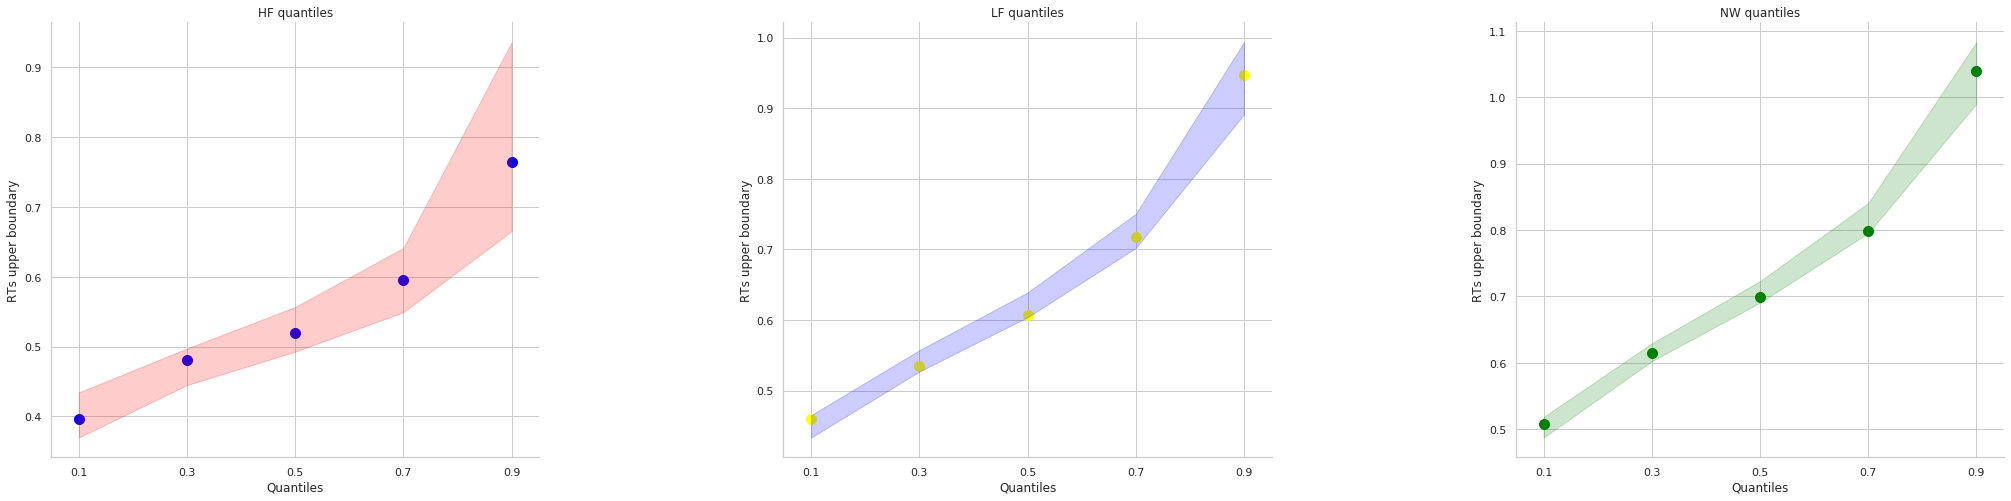

In [62]:
fig, axes = plt.subplots(1,3 , figsize=(35,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

axes[0].set_title('HF quantiles')
axes[1].set_title('LF quantiles')
axes[2].set_title('NW quantiles')

axes[0].scatter(quantiles, HF_quantile_ex, color='blue', s=100)
axes[1].scatter(quantiles, LF_quantile_ex, color='yellow', s=100)
axes[2].scatter(quantiles, NW_quantile_ex, color='green', s=100)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'red', alpha=0.2)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'blue', alpha=0.2)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'green', alpha=0.2)


for ax in axes:
        ax.set_xlabel('Quantiles')
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary')

sns.despine()
plt.savefig(plots_path + 'Quantiles Poseterior')

## Mean Accuracy and RT Posterior Plots

In [63]:
HF_data_rt_mean = HF_data['rt'].mean()
LF_data_rt_mean = LF_data['rt'].mean()
NW_data_rt_mean = NW_data['rt'].mean()

HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
NW_pred_rt_mean = NW_pred_rt.mean(axis=0)


HF_data_resp_mean = HF_data['response'].mean()
LF_data_resp_mean = LF_data['response'].mean()
NW_data_resp_mean = NW_data['response'].mean()

HF_pred_resp_mean = HF_pred_resp.mean(axis=0)
LF_pred_resp_mean = LF_pred_resp.mean(axis=0)
NW_pred_resp_mean = NW_pred_resp.mean(axis=0)


In [64]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)])

    ax.plot(xd, yd)
    ax.axvline(data_mean, color='red')

In [ ]:
fig, axes = plt.subplots(3,2 , figsize=(15,15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

axes[0][0].set_title('HF mean RT')
axes[0][1].set_title('HF mean Response')
axes[1][0].set_title('LF mean RT')
axes[1][1].set_title('LF mean Response')
axes[2][0].set_title('NW mean RT')
axes[2][1].set_title('NW mean Response')

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

plt.savefig(plots_path + 'Mean Accuracy and RT')